In [1]:
# Setup Notebook Environment
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as mtick
import seaborn as sns 
# extras for getting json (historical data)
import urllib3
from urllib3 import request
#print(urllib3.__version__)
import json
sns.set(style = "darkgrid")

In [2]:
# Get data for IL and St. Clair County vaccine administration.
# Remove header row

# St Clair county:
df = pd.read_csv('https://idph.illinois.gov/DPHPublicInformation/api/COVIDExport/GetVaccineAdministration?format=csv&countyName=St.%20Clair', skiprows=1)

# Illinois data:
df_il = pd.read_csv('https://idph.illinois.gov/DPHPublicInformation/api/COVIDExport/GetVaccineAdministration?countyname=&format=csv', skiprows=1)


In [3]:
# update column names
df.columns = ['County','VacToDate','DailyTotal','RollAvg', 'NumFulVac','RptDate','PerVac']
df_il.columns = ['County','VacToDate','DailyTotal','RollAvg', 'NumFulVac','RptDate','PerVac']
#df.head()

In [4]:
# Remove timestamp to align with historical infection data format.
df['RptDate'] = pd.to_datetime(df['RptDate']).dt.date
df_il['RptDate'] = pd.to_datetime(df_il['RptDate']).dt.date
#df.dtypes

In [5]:
# How is the county doing?
# Add the St. Clair data to IL's to compare vaccination rates.  

# reset the index values for St Clair county to data stacks correctly.
stc = df.reset_index(drop=True)
# combine data vertically
df_vac = pd.concat([df_il,stc], axis=0)

In [6]:
# Add day of week to data (compare some data on Fridays to reduce data points).
#  swap datatype to add day of week
df_vac['RptDate'] = pd.to_datetime(df_vac['RptDate'])
df_vac['dayOfWeek'] = df_vac['RptDate'].dt.day_name()
#  swap back to string for report date (makes charts easier)
df_vac['RptDate'] = pd.to_datetime(df_vac['RptDate']).dt.date

In [7]:
# Add values for percentage of population fully vaccinated (PerVac)
# Population values from http://www.dph.illinois.gov/covid19/vaccinedata?county=Illinois

ilpop = 12741080
stcpop = 261059

df_vac['newVacToDatePer'] = np.where(df_vac['County']=='Illinois',
                                     (df_vac['VacToDate'] - df_vac['NumFulVac'])/ilpop,
                                     (df_vac['VacToDate'] - df_vac['NumFulVac'])/stcpop)
#df_pd.head(10)


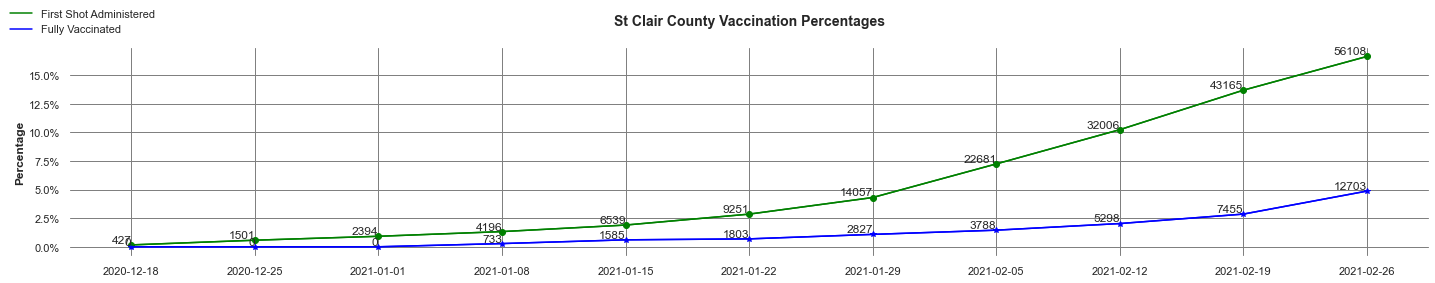

In [8]:
# Visual - Vaccination Percentages - St Clair County, IL

#set up values
stc_vac = df_vac.query('County == "St. Clair" & dayOfWeek == "Friday"')

x = stc_vac.RptDate

y = stc_vac.newVacToDatePer
y2 = stc_vac.PerVac

#set up plotting
fig, ax = plt.subplots()

#first plot - St Clair first shot administered
ax.plot(x, y, color = 'green', marker = 'o')
#Do some formatting
ax.set_title('St Clair County Vaccination Percentages\n', fontweight = 'bold', fontsize = '14')
ax.set_ylabel('Percentage', fontsize = '12', fontweight = 'bold')
ax.set_facecolor('white')
ax.grid(color = 'gray')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
#Set the x-axis to match the dates in the data.
ax.set_xticks(x)
ax.set_xticklabels(x)

#second plot - St Clair fully vaccinated
ax.plot(x, y2, color = 'blue', marker = '*')

fig1, = plt.plot(x,y, color = 'green')
fig2, = plt.plot(x,y2, color = 'blue')

# Create labels to show numbers behind the percentages
for index, v in stc_vac.iterrows(): 
        label1 = "{}".format(v['VacToDate']) # Number of total vaccinations
        label2 = "{}".format(v['NumFulVac']) # Number of people fully vaccinated
        ax.annotate(label1, (v['RptDate'], v['newVacToDatePer']), ha='right', va='bottom') 
        ax.annotate(label2, (v['RptDate'], v['PerVac']), ha='right', va='bottom')

fig.legend([fig1, fig2], ['First Shot Administered', 'Fully Vaccinated'], loc = 'upper left',
           frameon = False, facecolor = 'none')

fig.set_size_inches(20, 4)
fig.tight_layout()


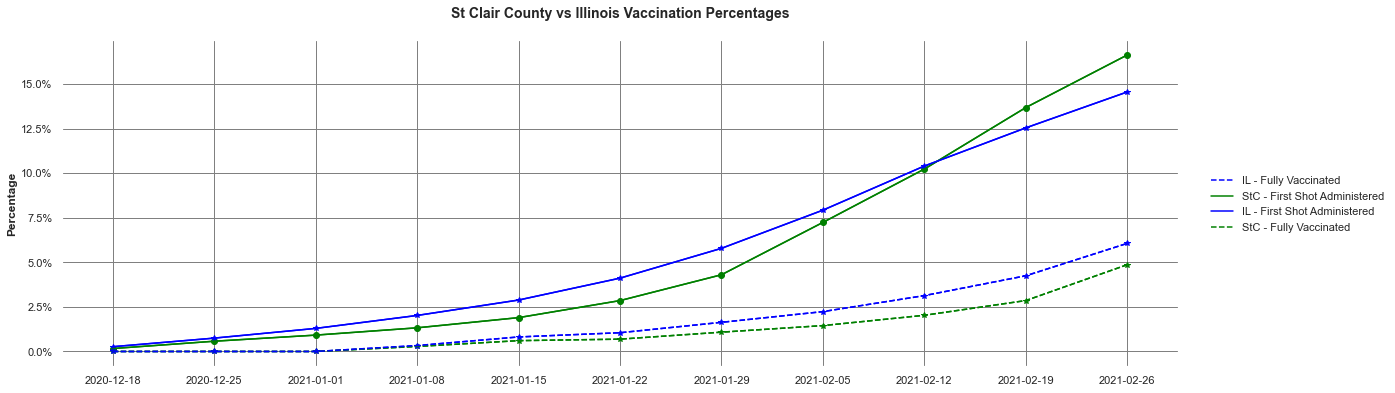

In [21]:
# Visual - Vaccination Percentages - St Clair County vs IL Statewide

#set up values
stc_vac = df_vac.query('County == "St. Clair" & dayOfWeek == "Friday"')
il_vac = df_vac.query('County == "Illinois" & dayOfWeek == "Friday"')

x = stc_vac.RptDate

y = stc_vac.newVacToDatePer
y2 = stc_vac.PerVac

y3 = il_vac.newVacToDatePer
y4 = il_vac.PerVac

#set up plotting

fig, ax = plt.subplots()

#first plot - St Clair first vaccination given
ax.plot(x, y, color = 'green', marker = 'o')
#Do some formatting
ax.set_title('St Clair County vs Illinois Vaccination Percentages\n', fontweight = 'bold', fontsize = '14')
ax.set_ylabel('Percentage', fontsize = '12', fontweight = 'bold')
ax.set_facecolor('white')
ax.grid(color = 'gray')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
#Set the x-axis to match the dates in the data.
ax.set_xticks(x)
ax.set_xticklabels(x)

#second plot - St Clair Fully Vaccinated
ax.plot(x, y2, color = 'green', linestyle = 'dashed', marker = '*')

#third plot - IL first vaccination
ax.plot(x, y3, color = 'blue', marker = '*')
#fourth plot - IL fully vaccinated
ax.plot(x, y4, color = 'blue', linestyle = 'dashed', marker = '*')

fig1, = plt.plot(x,y, color = 'green')
fig2, = plt.plot(x,y2, color = 'green', linestyle = 'dashed')
fig3, = plt.plot(x,y3, color = 'blue')
fig4, = plt.plot(x,y4, color = 'blue', linestyle = 'dashed')

fig.legend([fig4, fig1, fig3, fig2], ['IL - Fully Vaccinated','StC - First Shot Administered',
                                      'IL - First Shot Administered', 'StC - Fully Vaccinated'], loc = 'center right',
           frameon = False, facecolor = 'none', bbox_to_anchor=(1.05, 0.5))

fig.set_size_inches(20, 6)


In [10]:
# Retrieve County historical infection data (json)
http = urllib3.PoolManager()
url = 'https://idph.illinois.gov/DPHPublicInformation/api/COVID/GetCountyHistorical?countyName=St.%20Clair'
r = http.request('GET', url)
# check that was read correctly --> r.status

In [11]:
# decode json data into a dict and find the element containing the info needed ('values').
data = json.loads(r.data.decode('utf-8'))

#look at data --> data

In [12]:
# read the data into a dataframe, using the level found earlier.
df2 = pd.json_normalize(data, 'values')
#df2.head(2)

In [13]:
#pull date only from reportDate field.
df2['reportDate'] = pd.to_datetime(df2['reportDate']).dt.date
#print(df2['reportDate'])

In [14]:
# Remove un-needed columns.  Note:  data is St. Clair only so removing county column.
df2.drop(columns=['latitude', 'longitude', 'CountyName'], inplace =True)
#df2.head(2)

In [15]:
# Add the daily New Cases number to data frames. Convert to integer and deal with NaN on 3/17

df2['newCases'] = df2['confirmed_cases'] - df2['confirmed_cases'].shift(1)
df2['newCases'] = df2['newCases'].fillna(0).astype(int)
#df2.head(10)

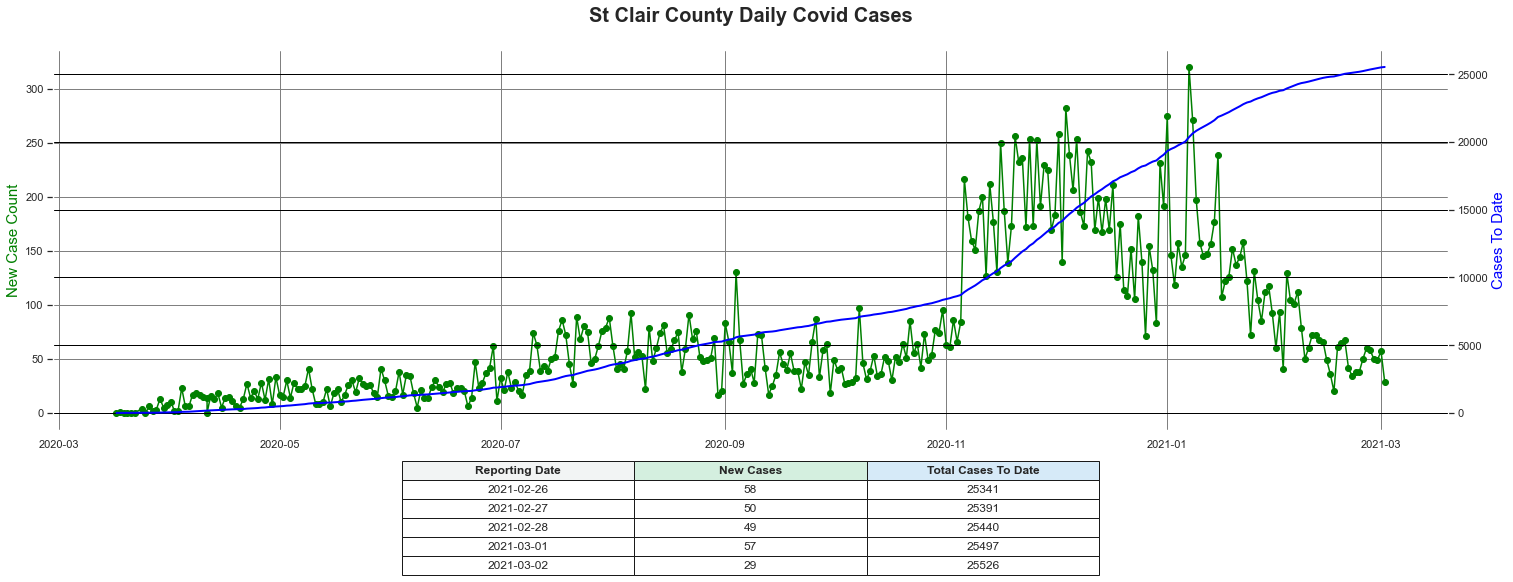

In [16]:
# Visual - Daily Covid cases with Total Cases to Date
# With different formatting and data table of last 5 days' numbers.

#set up values
x = df2.reportDate
y = df2.newCases

y2 = df2.confirmed_cases

#set up plotting - a different way from above (difficult to do with 2 y)

fig, ax = plt.subplots()

#first plot (new cases)
ax.plot(x, y, color ='green', marker = 'o')
ax.set_title("St Clair County Daily Covid Cases\n", fontweight = 'bold', fontsize = '20')
#ax.set_xlabel("Date", fontsize = '10')
ax.set_ylabel("New Case Count", color = 'green', fontsize = '15')
ax.set_facecolor('white')
ax.grid(color = 'gray')

#second plot (cases to date)
ax2 = ax.twinx()
ax2.plot(x, y2, color = 'blue', linewidth = '2')
ax2.set_ylabel("Cases To Date", color = 'blue', fontsize = '15')
ax2.grid(color = 'black')

# Set up table for last 5 days of data

# to get all columns --> cells = df2.tail(5)
cells = df2[['reportDate', 'newCases', 'confirmed_cases']].tail(5)
col_labels = ['Reporting Date', 'New Cases', 'Total Cases To Date']
vals = cells.values

table = ax.table(cellText=vals, colLabels=col_labels, 
                 cellLoc = 'center', loc='bottom', bbox = [0.25, -0.38, 0.5, 0.3])

## bbox format --> (indent, distance from chart bottom, cell width, cell height)

# add bold headers to table
for (row, col), cell in table.get_celld().items():
  if (row == 0) or (col == -1):
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))

#set custom colors for column headers.    
table[(0, 0)].set_facecolor("#F2F4F4")
table[(0, 1)].set_facecolor("#D4EFDF")
table[(0, 2)].set_facecolor("#D6EAF8")

table.set_fontsize(12)

fig.set_size_inches(25, 7)



In [17]:
# Join with vaccination progress info above.  (Vaccinations started in mid-December 2020.)

df3 = df.merge(df2, left_on = 'RptDate', right_on ='reportDate')

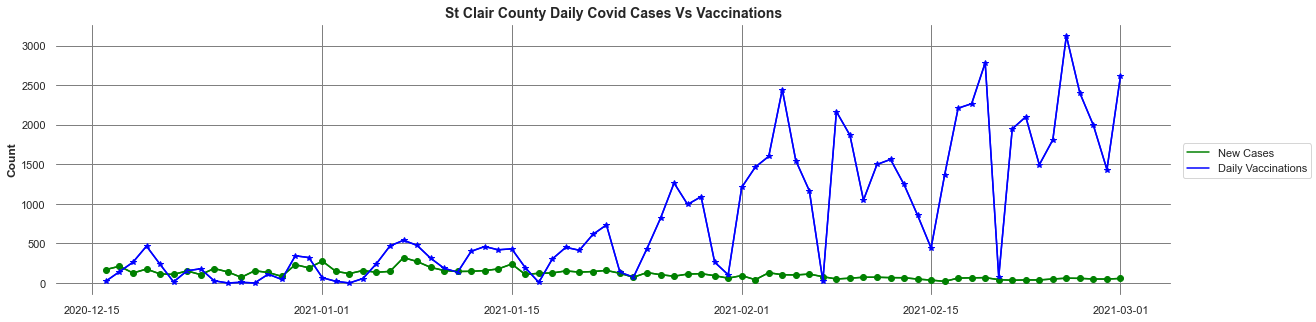

In [18]:
# Visual - Covid Daily Reported Cases vs Vaccinations in St. Clair County

#set up values
x = df3.reportDate
y = df3.newCases

y2 = df3.DailyTotal

#set up plotting - keeping this chart (right and left scales) b/c hoping it will be needed soon.

fig, ax = plt.subplots()

#first plot - note that the lengend controls the line color.  Color in plot controls marker color
ax.plot(x, y, color = 'green', marker = 'o')
#Do some formatting
ax.set_title('St Clair County Daily Covid Cases Vs Vaccinations', fontweight = 'bold', fontsize = '14')
ax.set_ylabel('Count', fontsize = '12', fontweight = 'bold')
ax.set_facecolor('white')
ax.grid(color = 'gray')

#second plot
ax.plot(x, y2, color = 'blue', marker = '*')

# Setup for 2 y axis - nice when the number of vaccinations widely passes number of new cases.
# ax2 = ax.twinx()
# ax2.plot(x, y2, color = 'blue')
# ax2.set_ylabel("New Vaccination Count", color = 'blue', fontsize = '12')

fig1, = plt.plot(x,y, color = 'green')
fig2, = plt.plot(x,y2, color = 'blue')

fig.legend([fig1, fig2], ['New Cases', 'Daily Vaccinations'], loc = 'center right', facecolor = 'white')

fig.set_size_inches(20, 5)
